# Time Series - Recurrent Neural Network (RNN)

## Summary:
**Dataset:** Daily temperature values with their corresponding dates  
**Model:** Predicts the temperature for the following date  
**Particulars:** Sliding window containing time lags, neural-network with recurrent layers (LSTM and GRU)

## Table of Contents:
* Section 1 - Exploring data
* Section 2 - Data Pre-processing: Scaling, Sliding Window (Lags), Splitting
* Section 3 - Generating Model 1 (LSTM Nodes) and Training
* Section 4 - Generating Model 2 (GRU Nodes) and Training

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Importing data: Daily temperature values spanning 10 years, with their corresponding date
df = pd.read_csv('temperatures.csv')

# Section 1 - Exploring Data

,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


,Date,Temperature
3648,1990-12-30,24.4
3649,1990-12-31,24.6


,Temperature
count,3650.000000
mean,20.009151
std,6.108353
min,7.000000
25%,15.400000
50%,18.900000
75%,23.000000
max,43.300000




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3650 non-null   object 
 1   Temperature  3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB




<AxesSubplot:>

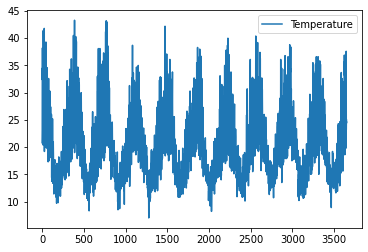

In [3]:
# Exploring dataset values

df.head()
print('\n')
df.tail(2)
print('\n')
df.describe()
print('\n')
df.info()
print('\n')
df.plot()

# Section 2 - Data Pre-processing: Scaling, Sliding Window (Lags), Splitting

In [4]:
# Converting the date column from type string to DateTime, and setting it as the 

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

data = df.copy()
data.shape

(3650, 1)

In [5]:
# Scaling data

valid_ratio = 0.25
no_of_lags = 25

# Stop mechanism to train scaler only on training set
stop = int((len(data)-no_of_lags)*(1-valid_ratio)+no_of_lags)

scaler = MinMaxScaler()
scaler.fit(data[0:stop])
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=['Scaled Temp.'], index=data.index)

MinMaxScaler()

In [6]:
# Generating a sliding window with time lags

for i in range(1, no_of_lags+1):
    data_scaled['shift_{}'.format(i)] = data_scaled['Scaled Temp.'].shift(i)

data_scaled.head(4)

,Scaled Temp.,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23,shift_24,shift_25
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,0.699725,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-03,0.757576,0.699725,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-04,0.377410,0.757576,0.699725,0.856749,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Reversing column order for forward feeding into RNN
data_scaled_ff = data_scaled.iloc[:,::-1]

# Dropping rows with NaN (incomplete sequences) and separating input and output columns
x = data_scaled_ff.dropna().drop('Scaled Temp.', axis=1)
y = data_scaled_ff.dropna()[['Scaled Temp.']]

x.shape
print('\n')
y.shape

(3625, 25)

(3625, 1)

In [8]:
# Splitting data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=valid_ratio, shuffle=False, random_state=1)

x_train.shape
print('\n')
x_val.shape

(2718, 25)

(907, 25)

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Scaled Temp.')

Text(0.5, 1.0, 'Data')

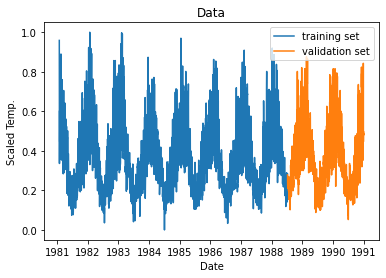

In [9]:
fig, ax = plt.subplots()

ax.plot(y_train, label = 'training set')
ax.plot(y_val, label = 'validation set')
ax.set_xlabel('Date')
ax.set_ylabel('Scaled Temp.')
ax.set_title('Data')
ax.legend(loc='upper right')

# Section 3 - Generating Model 1 (LSTM Nodes) and Training

In [10]:
# Generating model 1 with LSTM nodes

K.clear_session()
tf.random.set_seed(0)
random.seed(0)

model_1 = Sequential([
    LSTM(50, return_sequences=True, input_shape=[None, 1]),
    LSTM(50),
    Dense(1)])

model_1.compile(loss="mse", optimizer="adam")

h_1 = model_1.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

y_pred = model_1.predict(x_val)
y_pred_df = pd.DataFrame(y_pred, columns=['Scaled Temp.'], index=y_val.index)

Epoch 1/20
85/85 [==============================] - 15s 19ms/step - loss: 0.0227 - val_loss: 0.0152
Epoch 2/20
85/85 [==============================] - 1s 13ms/step - loss: 0.0157 - val_loss: 0.0142
Epoch 3/20
85/85 [==============================] - 1s 12ms/step - loss: 0.0160 - val_loss: 0.0140
Epoch 4/20
85/85 [==============================] - 1s 10ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 5/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 6/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 7/20
85/85 [==============================] - 1s 9ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 8/20
85/85 [==============================] - 1s 9ms/step - loss: 0.0147 - val_loss: 0.0130
Epoch 9/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0143 - val_loss: 0.0123
Epoch 10/20
85/85 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 0.0111
Epoch 11/20
85

In [11]:
# Inverse scaling to obtain temperature values
temp_pred = scaler.inverse_transform(y_pred)
temp_pred_df = pd.DataFrame(temp_pred, columns=['Temperature'], index=y_val.index)

temp_val = scaler.inverse_transform(y_val)
temp_val_df = pd.DataFrame(temp_val, columns=['Temperature'], index=y_val.index)

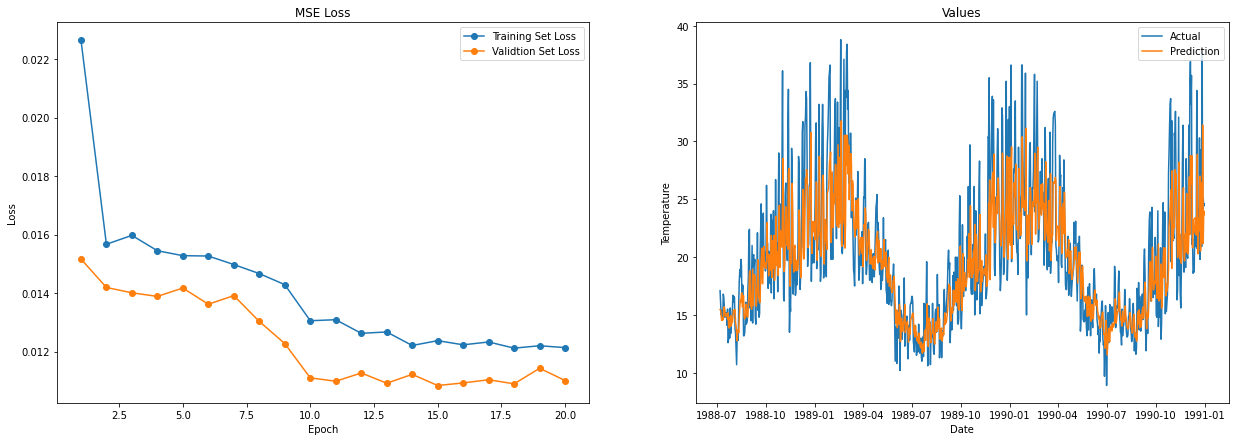

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

_ = ax[0].plot(range(1, len(h_1.history['loss']) + 1), h_1.history['loss'], 'o-', label = 'Training Set Loss')
_ = ax[0].plot(range(1, len(h_1.history['val_loss']) + 1), h_1.history['val_loss'], 'o-', label = 'Validtion Set Loss')
_ = ax[0].set_xlabel('Epoch')
_ = ax[0].set_ylabel('Loss')
_ = ax[0].set_title('MSE Loss')
_ = ax[0].legend()

_ = ax[1].plot(temp_val_df, label = 'Actual')
_ = ax[1].plot(temp_pred_df, label = 'Prediction')
_ = ax[1].set_xlabel('Date')
_ = ax[1].set_ylabel('Temperature')
_ = ax[1].set_title('Values')
_ = ax[1].legend(loc='upper right')

In [13]:
# Displaying the best valdiation set root mean squared error (RMSE) loss and training epoch value
val_losses_1 = np.array(h_1.history['val_loss'])
best_epoch_1 = np.argmin(val_losses_1) + 1
min_val_loss_1 = np.min(val_losses_1)
print('The lowest RMSE loss on the validation set was %s, at training epoch #%s' % (round(sqrt(min_val_loss_1), 4), best_epoch_1) )

The lowest RMSE loss on the validation set was 0.1041, at training epoch #15


# Section 4 - Generating Model 2 (GRU Nodes) and Training

In [14]:
# Generating model 2 with LSTM nodes

K.clear_session()
tf.random.set_seed(0)
random.seed(0)

model_2 = Sequential([
    GRU(50, return_sequences=True, input_shape=[None, 1]),
    GRU(50),
    Dense(1)])

model_2.compile(loss="mse", optimizer="adam")

h_2 = model_2.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

y_pred = model_2.predict(x_val)
y_pred_df = pd.DataFrame(y_pred, columns=['Scaled Temp.'], index=y_val.index)

Epoch 1/20
85/85 [==============================] - 6s 17ms/step - loss: 0.0198 - val_loss: 0.0137
Epoch 2/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.0124
Epoch 3/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0135 - val_loss: 0.0111
Epoch 4/20
85/85 [==============================] - 1s 13ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 5/20
85/85 [==============================] - 1s 11ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 6/20
85/85 [==============================] - 1s 10ms/step - loss: 0.0126 - val_loss: 0.0110
Epoch 7/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 8/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0123 - val_loss: 0.0109
Epoch 9/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0122 - val_loss: 0.0108
Epoch 10/20
85/85 [==============================] - 1s 8ms/step - loss: 0.0121 - val_loss: 0.0109
Epoch 11/20
85/

In [15]:
# Inverse scaling to obtain temperature values
temp_pred = scaler.inverse_transform(y_pred)
temp_pred_df = pd.DataFrame(temp_pred, columns=['Temperature'], index=y_val.index)

temp_val = scaler.inverse_transform(y_val)
temp_val_df = pd.DataFrame(temp_val, columns=['Temperature'], index=y_val.index)

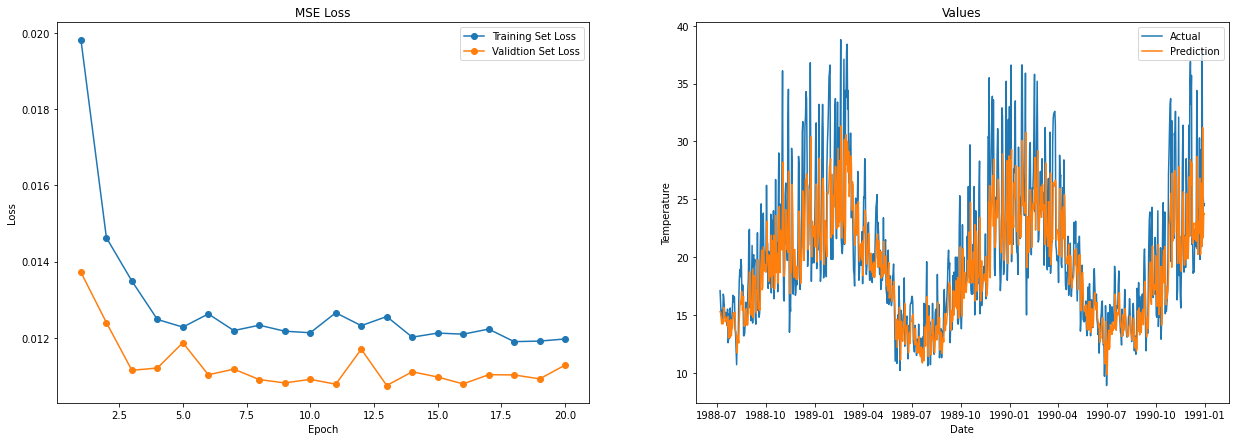

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

_ = ax[0].plot(range(1, len(h_2.history['loss']) + 1), h_2.history['loss'], 'o-', label = 'Training Set Loss')
_ = ax[0].plot(range(1, len(h_2.history['val_loss']) + 1), h_2.history['val_loss'], 'o-', label = 'Validtion Set Loss')
_ = ax[0].set_xlabel('Epoch')
_ = ax[0].set_ylabel('Loss')
_ = ax[0].set_title('MSE Loss')
_ = ax[0].legend()

_ = ax[1].plot(temp_val_df, label = 'Actual')
_ = ax[1].plot(temp_pred_df, label = 'Prediction')
_ = ax[1].set_xlabel('Date')
_ = ax[1].set_ylabel('Temperature')
_ = ax[1].set_title('Values')
_ = ax[1].legend(loc='upper right')

In [17]:
# Displaying the best valdiation set root mean squared error (RMSE) loss and training epoch value
val_losses_2 = np.array(h_2.history['val_loss'])
best_epoch_2 = np.argmin(val_losses_2) + 1
min_val_loss_2 = np.min(val_losses_2)
print('The lowest RMSE loss on the validation set was %s, at training epoch #%s' % (round(sqrt(min_val_loss_2), 4), best_epoch_2) )

The lowest RMSE loss on the validation set was 0.1036, at training epoch #13
